In [10]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/1175342693.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [11]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.

    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.

    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

In [12]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [13]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f

    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif

      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [14]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])

      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)

      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

In [15]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.c = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    reward = reward if reward is not None else 0
    self._t += 1
    if previous_action is not None:
      self._N_t[previous_action] += 1
      alpha_t = 1 / self._N_t[previous_action]
      Q_tm1 = self._Q_t[previous_action]
      self._Q_t[previous_action] = Q_tm1 + alpha_t * (reward - Q_tm1) 
    
    upper_bound = np.sqrt(np.log(self._t) / self._N_t)
    ucb = self._Q_t + self.c * upper_bound
    ucb[np.isnan(ucb)] = np.inf # setting to infinity to prioritise in the next step
    ucb = ucb + np.random.uniform(size = ucb.shape,high = 1e-3)
    
    return np.argmax(ucb)

  def reset(self):
    self._N_t = np.zeros(self._number_of_arms, dtype=int)  # Number of times each arm was pulled
    self._Q_t = np.zeros(self._number_of_arms, dtype=float)  
    self._t = 0  


In [16]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    self._t += 1
    reward = reward if reward is not None else 0
    epsilon = self._epsilon(self._t) if callable(self._epsilon) else self._epsilon
    p = np.random.rand()
    if previous_action is not None:
        self._N_t[previous_action] += 1 
        alpha_t = 1 / self._N_t[previous_action]
        self._Q_t[previous_action] = self._Q_t[previous_action] + alpha_t * (reward - self._Q_t[previous_action]) 
    if p > epsilon:
      noise = np.random.uniform(size= self._Q_t.shape,high=1e-3)
      action = np.argmax(self._Q_t + noise) 
    else:
      action = np.random.choice(self._number_of_arms)
      
    return action

  def reset(self):
    self._Q_t = np.zeros(self._number_of_arms, dtype=float)  # Total reward of each arm
    self._N_t = np.zeros(self._number_of_arms, dtype=int)  # Number of times each arm was pulled
    self._t = 0  


In [17]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self._baseline = baseline
    self._number_of_arms = number_of_arms
    self._step_size = step_size
    self.reset()

  def step(self, previous_action, reward):
    reward = reward if reward is not None else 0
    if self._baseline:
      self._average_reward = self._average_reward + self._step_size * (reward - self._average_reward)
    self._t += 1

    preferences_sq_sum = np.sum(self._preferences**2) 

    if previous_action is not None:
        grad_log_policy = - 2 * self._preferences / preferences_sq_sum
        grad_log_policy[previous_action] += (2 / (self._preferences[previous_action]))
        self._preferences += self._step_size * (reward - self._average_reward) * grad_log_policy

    
    
    policy = self._preferences**2 / (np.sum(self._preferences**2))  
    action = np.random.choice(self._number_of_arms, p=policy)
    return action
  def reset(self):
    self._preferences = np.ones(self._number_of_arms, dtype=float)
    self._average_reward = 0
    self._t = 0



In [18]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: invalid value encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)
/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: divide by zero encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)


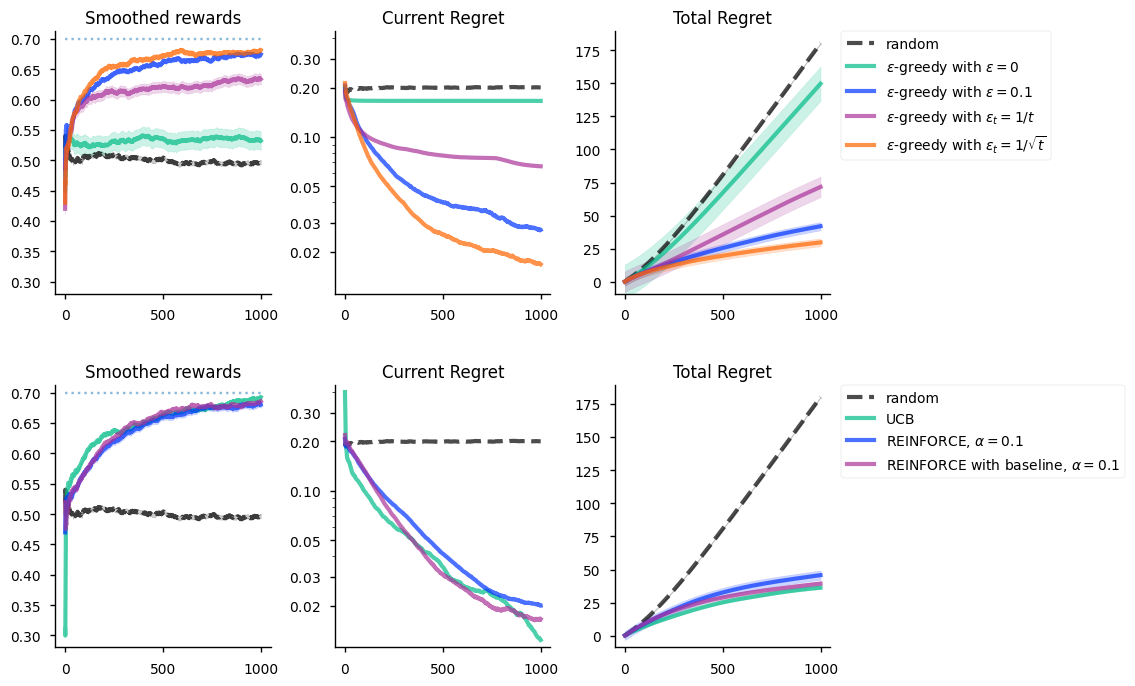

In [19]:
experiment1.show()

In [20]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: invalid value encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)
/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: divide by zero encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)


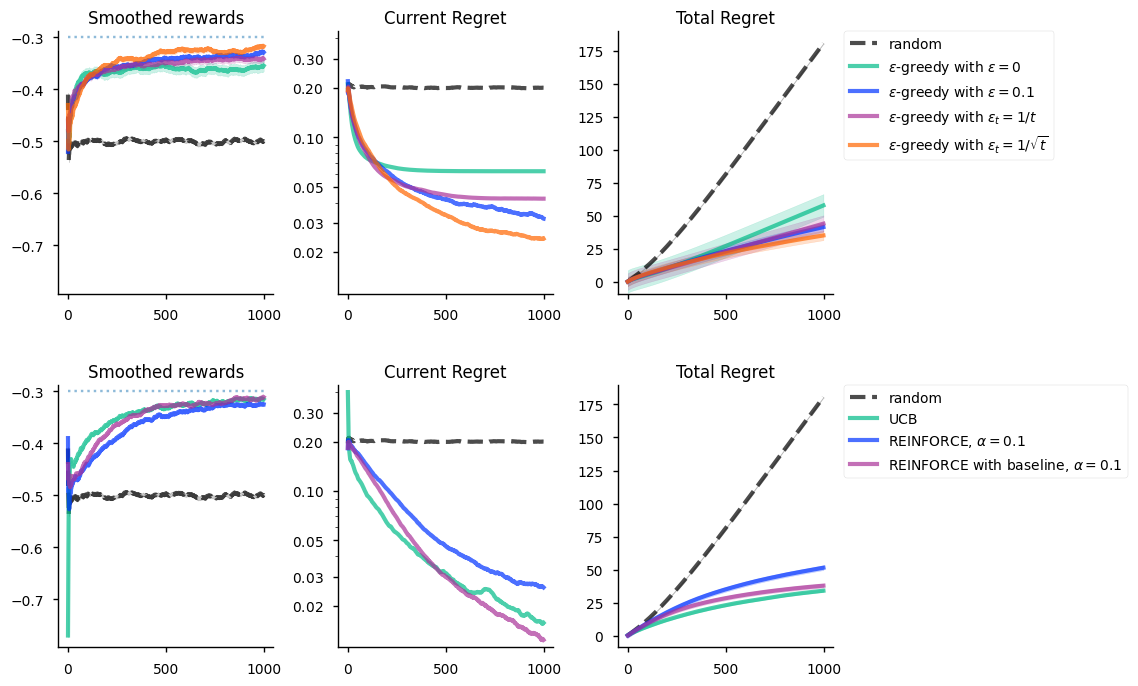

In [21]:
experiment2.show()

In [22]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

In [23]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: invalid value encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)
/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: divide by zero encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)


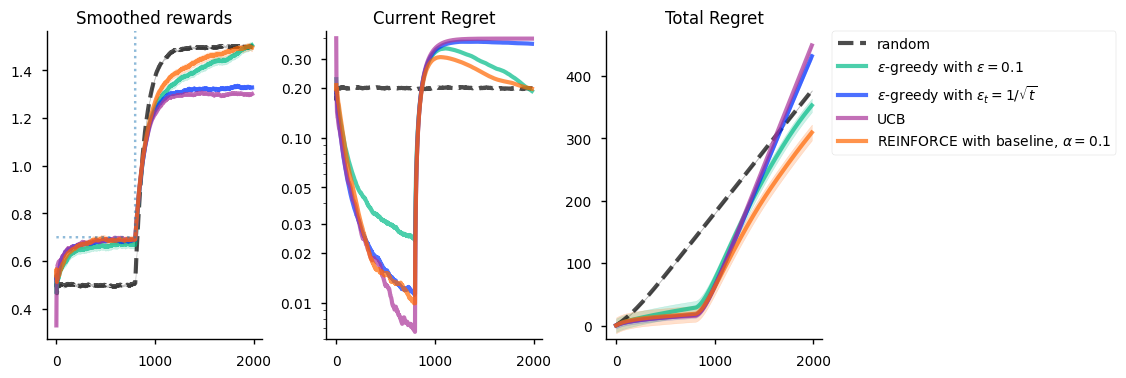

In [24]:
experiment3.show()

/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: invalid value encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)
/var/folders/nz/gfmljb2n1tzf894yqww7gltm0000gp/T/ipykernel_92131/2800859060.py:17: RuntimeWarning: divide by zero encountered in divide
  upper_bound = np.sqrt(np.log(self._t) / self._N_t)


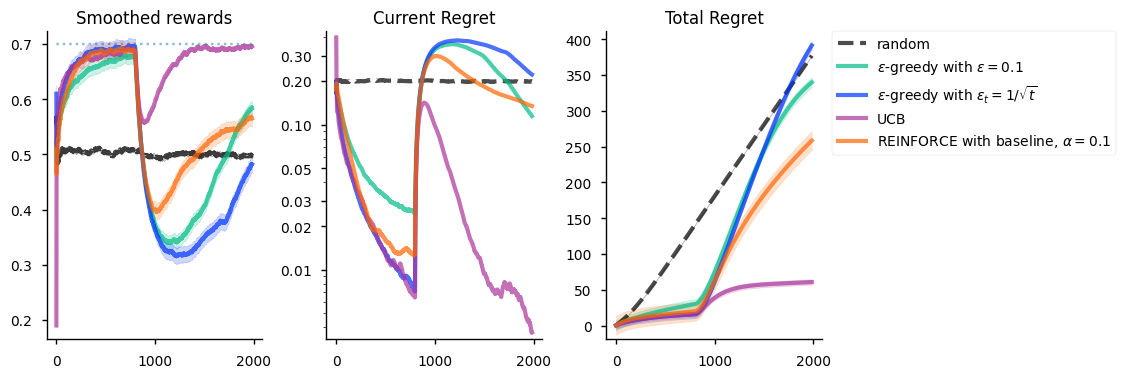

In [25]:
experiment4.show()